In [1]:
import os
import re
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from indoNLP.preprocessing import (
    emoji_to_words,
    remove_html,
    remove_url,
    replace_slang,
    replace_word_elongation,
)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

In [2]:
local = "../data/"
if os.path.isdir(local):
    main_dir = local
else:
    main_dir = "https://raw.githubusercontent.com/Hyuto/skripsi/master/data/"

In [3]:
data = pd.read_csv(main_dir + "sample-data.csv")
data.head()

,date,url,user,content,label
0,2021-09-02 01:39:05+00:00,https://twitter.com/no_nykrstnd/status/1433243...,no_nykrstnd,"-Dari hasil monitoring, calon Vaksin Merah Put...",0.0
1,2021-07-15 06:09:36+00:00,https://twitter.com/DakwahMujahidah/status/141...,DakwahMujahidah,[PODCAST] Ngomong Politik - Ilusi Penguatan Ke...,0.0
2,2021-07-05 08:57:50+00:00,https://twitter.com/gamisjohor/status/14119725...,gamisjohor,3. GAMIS menyambut baik saranan daripada YAB P...,2.0
3,2021-09-09 09:17:58+00:00,https://twitter.com/inyesaw/status/14358952423...,inyesaw,@txtdaribogor Abis vaksin terbitlah positif covid,4.0
4,2021-01-02 04:37:14+00:00,https://twitter.com/pringgolakseno/status/1345...,pringgolakseno,"Gambling, vaksin sama ga divaksin.\nGa divaksi...",4.0


In [4]:
data.dropna(inplace=True)
data["date"] = pd.to_datetime(data["date"]).dt.tz_localize(None)
data["label"] = data["label"].astype(int)
# data = data[data["label"] > 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     999 non-null    datetime64[ns]
 1   url      999 non-null    object        
 2   user     999 non-null    object        
 3   content  999 non-null    object        
 4   label    999 non-null    int32         
dtypes: datetime64[ns](1), int32(1), object(3)
memory usage: 42.9+ KB


In [5]:
STEMMER = StemmerFactory().create_stemmer()


def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text, flags=re.UNICODE)  # remove whitespace
    text = emoji_to_words(text)  # remove emoji
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("ascii")
    text = remove_html(text)  # remove html tags
    text = remove_url(text)  # remove url
    text = replace_word_elongation(text) # replace WE
    text = replace_slang(text)  # replace slang words
    # text = remove_stopwords(text)
    text = text.translate(str.maketrans("", "", string.digits))  # remove numbers
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # remove punctuation
    text = " ".join(text.split())
    text = STEMMER.stem(text)
    return " ".join(text.split())

In [6]:
data["cleaned"] = [preprocessing(x) for x in tqdm(data["content"].values)]

  0%|          | 0/999 [00:00<?, ?it/s]

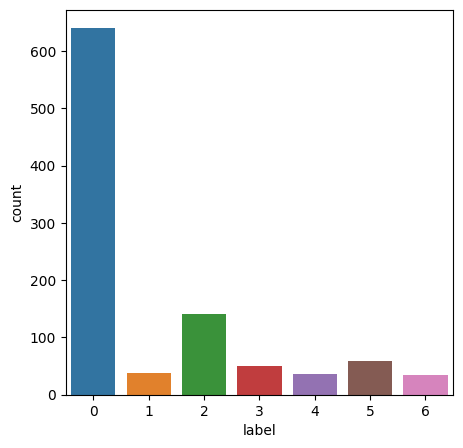

In [7]:
plt.figure(figsize=(5, 5))
sns.countplot(data=data, x="label")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import *

In [9]:
pipe = Pipeline(
    [
        ("tf-idf", TfidfVectorizer(max_features=3000)),
        ("svm", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=2022)),
    ]
)

cv = StratifiedKFold(shuffle=True, random_state=2022)

param_grid = {
    "svm__C": np.arange(1, 4.5, 0.1),
}
search = GridSearchCV(pipe, param_grid, cv=cv)
search.fit(data["cleaned"].values, data["label"].values)
search.best_params_

{'svm__C': 3.9000000000000026}

[]

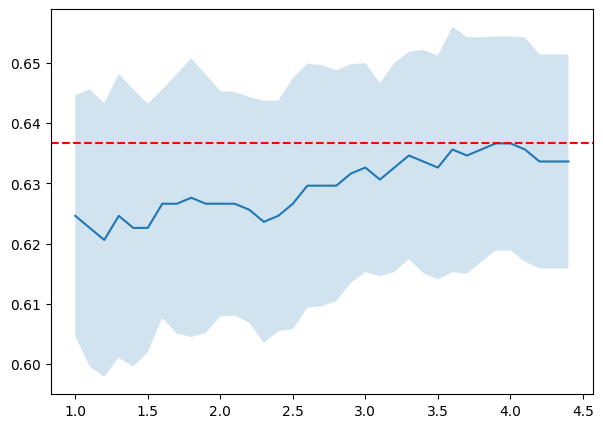

In [10]:
plt.figure(figsize=(7, 5))
sns.lineplot(x=np.arange(1, 4.5, 0.1), y=search.cv_results_["mean_test_score"])
plt.axhline(y=search.cv_results_["mean_test_score"].max(), color='r', linestyle='--')
plt.fill_between(
    np.arange(1, 4.5, 0.1),
    search.cv_results_["mean_test_score"] - search.cv_results_["std_test_score"],
    search.cv_results_["mean_test_score"] + search.cv_results_["std_test_score"],
    alpha=0.2,
)
plt.plot()

In [11]:
pipe = Pipeline(
    [
        ("tf-idf", TfidfVectorizer(max_features=3000)),
        ("svm", SVC(C=3.9, kernel="linear", probability=True, class_weight="balanced", random_state=2022)),
    ]
)

scores = cross_val_score(pipe, data["cleaned"].values, data["label"].values, cv=5)
scores.mean()

0.6366582914572864

In [12]:
pipe = Pipeline(
    [
        ("tf-idf", TfidfVectorizer(max_features=3000)),
        ("svm", SVC(C=3.9, kernel="linear", probability=True, class_weight="balanced", random_state=2022)),
    ]
)

x_train, x_test, y_train, y_test = train_test_split(
    data["cleaned"].values,
    data["label"].values,
    test_size=0.2,
    random_state=2022,
    stratify=data["label"].values,
)

pipe.fit(x_train, y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer(max_features=3000)),
                ('svm',
                 SVC(C=3.9, class_weight='balanced', kernel='linear',
                     probability=True, random_state=2022))])

In [13]:
print(f"Accuracy : {accuracy_score(y_test, pipe.predict(x_test))}")
print(f"F1 : {f1_score(y_test, pipe.predict(x_test), average=None)}")

Accuracy : 0.65
F1 : [0.81003584 0.22222222 0.45614035 0.22222222 0.         0.10526316
 0.        ]


In [15]:
from onnx.checker import check_model
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

os.makedirs("../output", exist_ok=True)

initial_type = [("words", StringTensorType([None, 1]))]
options = {"svm": {"zipmap": False}}
onnx_model = convert_sklearn(pipe, initial_types=initial_type, options=options)
with open("../output/model.onnx", "wb") as writer:
    writer.write(onnx_model.SerializeToString())
check_model(onnx_model)

In [16]:
!python -m onnxruntime.tools.convert_onnx_models_to_ort "../output/model.onnx"

Converting models with optimization style 'Fixed' and level 'all'
Converting optimized ONNX model C:\Users\Wahyu Setianto\Desktop\Github\skripsi\output\model.onnx to ORT format model C:\Users\Wahyu Setianto\Desktop\Github\skripsi\output\model.ort
Converted 1/1 models successfully.
Generating config file from ORT format models with optimization style 'Fixed' and level 'all'
Converting models with optimization style 'Runtime' and level 'all'
Converting optimized ONNX model C:\Users\Wahyu Setianto\Desktop\Github\skripsi\output\model.onnx to ORT format model C:\Users\Wahyu Setianto\Desktop\Github\skripsi\output\model.with_runtime_opt.ort
Converted 1/1 models successfully.
Converting models again without runtime optimizations to generate a complete config file. These converted models are temporary and will be deleted.
Converting optimized ONNX model C:\Users\Wahyu Setianto\Desktop\Github\skripsi\output\model.onnx to ORT format model C:\Users\Wahyu Setianto\Desktop\Github\skripsi\output\tmpj

2022-10-11 16:07:29,640 ort_format_model.utils [INFO] - Created config in C:\Users\Wahyu Setianto\Desktop\Github\skripsi\output\model.required_operators.config
2022-10-11 16:07:29,970 ort_format_model.utils [INFO] - Created config in C:\Users\Wahyu Setianto\Desktop\Github\skripsi\output\model.required_operators.with_runtime_opt.config
